# CIS 545 Final Project

## 0. Introduction and Recap

This project builds on the structure of HW4 and aims to explore and evaluate different models to determine the best performing model for predicting the number of stars of Amazon reviews. 

### 0.1 Packages and Raw Data

In [0]:
# install stuff
%%capture
!pip install -U gensim
!pip install urllib2

In [3]:
# check gensim version
import gensim
gensim.__version__

'3.8.1'

In [0]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf

import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from datetime import *
from operator import itemgetter


In [0]:
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

### 0.2 Useful Functions

In [0]:
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

In [0]:

def lookup_docs(corpus, indices):
  indices = np.sort(np.unique(np.array(indices)))
  j = 0
  res = []
  for i, doc in enumerate(corpus):
    if i == indices[j]:
      j += 1
      res.append(doc)
      if i == indices[-1]:
        break
  return res


In [0]:

def translate_review(review, reviews_dict):
  string = ''
  for pair in review:
    word = reviews_dict[pair[0]]
    string += ''.join((word+' ')*int(pair[1]))
  string = string.strip()
  return string

In [0]:
def make_tfidf(reviews_bow):
    model = TfidfModel(reviews_bow, normalize=True)
    vector = model[reviews_bow]
    return vector

In [0]:
reviews_tfidf = make_tfidf(reviews_bow)

In [0]:
def densify(sparse, columns):
  dt = np.zeros([len(sparse),columns])
  for i,doc in enumerate(sparse):
    for (word, freq) in doc:
      dt[i, word] = freq
  return dt


In [0]:

def PCA_reconstruction(sparse, gsdict, cutoff):
  model = LsiModel(sparse, id2word=gsdict, num_topics=cutoff)
  vector = model[sparse]
  sv = np.zeros([len(model.projection.s),len(sparse)])
  for i, v in enumerate(vector):
    for (m,n) in v:
      sv[m,i] = n
  recs = np.matmul(model.projection.u, sv)
  original = densify(sparse, len(gsdict)).transpose()
  diff =  original - recs
  error = np.linalg.norm(diff)/np.linalg.norm(original)
  return error


In [0]:
def evaluate_model(X, review_times, y):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    rfor = RandomForestClassifier(n_estimators=70, random_state=1911)

    rfor.fit(X_train, y_train)  
    return rfor.score(X_test, y_test)

In [0]:
def evaluate_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model = LsiModel(X_orig, id2word=X_dict, num_topics=cutoff)
        vector = model[X_orig]
        matrix = densify(vector, cutoff)
        res = evaluate_model(matrix, X_times, y)
        results.append(res)
    return results


In [0]:
# results = evaluate_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, range(10,40))

### 0.3 Deciding on the Data to use

In HW4, we utilized gensim package to obtain bag-of-words representation of the Amazon reviews and converted the data to TF-IDF scores. Next, we used LsiModel to perform PCA on the data and kept different numbers of principle components to evaluate its performance. And finally we densified the data into a matrix appropriate for training. 

So far, Random Forest has yielded an accuracy score of ~79% given the dimentionality reduced dataset of 40 principle components. Let's plot the accuracy versus the number of principle componenets.

In [0]:
results=[0.7596, 0.7645, 0.7751, 0.7777, 0.7795, 0.78515, 0.7852, 0.783, 0.79175, 0.792, 0.79325, 0.79575, 0.79315, 0.79495, 0.79655, 0.79615, 0.79375, 0.7959, 0.797, 0.79515, 0.796, 0.7969, 0.79625, 0.79855, 0.7954, 0.79595, 0.79645, 0.7972, 0.7953, 0.79505]

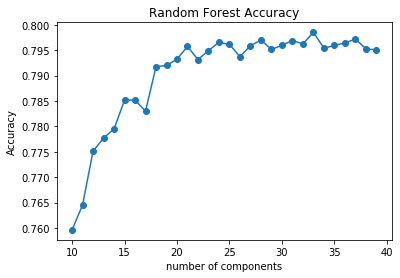

In [17]:
plt.figure()
plt.plot(range(10,40), results, '-o')
plt.title('Random Forest Accuracy')
plt.xlabel('number of components')
plt.ylabel('Accuracy')
plt.show()

As can be seen from the plot, the number of components is no longer a factor that significantly affects model accuracy. Furthermore, ss noted in HW4, there is no "plateau" in the plot which visualizes the percentage of variance explained versus the number of components, which does not give clear indication of how many components to keep. Thus, to maintain generality, this project will use a dataset which keeps 40 principle components in PCA. For now I exclude the time feature.


In [0]:
np.random.seed(1911)
cutoff = 40
model = LsiModel(reviews_tfidf, id2word=reviews_dict, num_topics=cutoff)
vector = model[reviews_tfidf]
data = densify(vector, cutoff)
# data = np.hstack((data, reviews_times.reshape(-1,1)))

## 1. Building the models

### 1.0 prepare the data for training

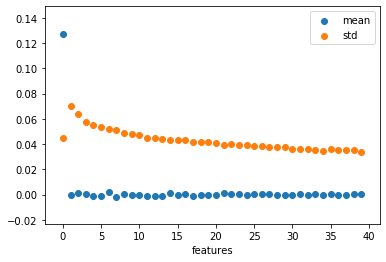

In [19]:
N, k = data.shape
mean = np.zeros(k)
std = np.zeros(k)
for i in range(k):
  mean[i] = np.mean(data[:,i])
  std[i] = np.std(data[:,i])
plt.figure()
plt.scatter(range(k),mean,label='mean')
plt.scatter(range(k),std,label='std')
plt.xlabel('features')
plt.legend(loc='best')
plt.show()

The data seems to have similar scale, I will first use them for training without normalization or standardization. 

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.3)
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

Balanced dataset?

In classification, inbalance happens in the dataset when there is a disporportionate ratio of instances in each class. As machine learning algorithms usually aim to maximize the overall accuracy, the rarer class would be overlooked by the algorithm. It is not desirable since we each class is significant to us. Let's inspect the number of instances in each class.

In [21]:
from collections import Counter
print(dict(Counter(y)))
print(dict(Counter(y_train)))

{1: 20000, 2: 20000, 3: 20000, 4: 20000, 5: 20000}
{2: 13977, 4: 14047, 3: 13994, 1: 13995, 5: 13987}


It seems that we have very balanced classes - same number of instances in each class.

### 1.1 Logistic Regression & Support Vector Machine
random forest has set a decent baseline, let's try other models to see if we can we can improve its performance. 


In [0]:
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem

In [56]:
lr = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=500) # set higher max_iter to ensure convergence
lr.fit(x_train,y_train)
print('logistic regression score: {}'.format(lr.score(x_test,y_test)))

# implements an svm using a linear kernel
# The fit time for svm scales at least quadratically with the number of samples 
# so it may be impractical for large datasets
# can perform 'kernel trick' by applying Nystroem which approximates a kernel map
svm = LinearSVC()
svm.fit(x_train,y_train)
score = dict({'linear':svm.score(x_test,y_test)})
for kernel in ['rbf','poly','sigmoid']:
  if kernel == 'poly':
    for degree in [2,3,4]:
      kernel_map = Nystroem(kernel=kernel,n_components=40) 
      x_train_kernel = kernel_map.fit_transform(x_train)
      x_test_kernel = kernel_map.transform(x_test)
      svm.fit(x_train_kernel,y_train)     
      score[kernel+str(degree)] = svm.score(x_test_kernel,y_test)
  else:
      kernel_map = Nystroem(kernel=kernel,n_components=40)
      kernel_map = Nystroem(kernel=kernel,n_components=40) 
      x_train_kernel = kernel_map.fit_transform(x_train)
      x_test_kernel = kernel_map.transform(x_test)
      svm.fit(x_train_kernel,y_train)     
      score[kernel] = svm.score(x_test_kernel,y_test)
print("SVM accuracy with different kernels: {}".format(score))



logistic regression score: 0.7837
SVM accuracy with different kernels: {'linear': 0.7866333333333333, 'rbf': 0.7786, 'poly2': 0.7796, 'poly3': 0.7807, 'poly4': 0.7818, 'sigmoid': 0.7734}


Judging from accuracy scores, the (marginally) better kernel to use for the svm is linear. 

### 1.1.1 Hyper-parameter tuning
In order to improve the training accuracy, it's necessary to tune the hyper-parameters. In this case, validation curve is used to evaluate accuracy versus regularization stength, a hyper-parameter that logistic regression and svm share.

In [0]:
from sklearn.model_selection import learning_curve, validation_curve

param_range = [0.01,0.1,1,10,100]
param_name = 'C'

# use linear kernel for svm
svm = LinearSVC()
lr = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=500) 

models = {}
models['Logistic Regression'] = lr
models['SVM'] = svm

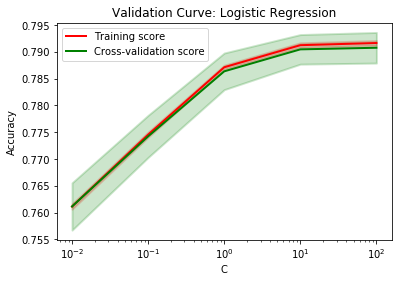

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


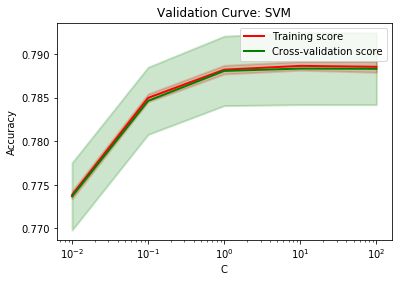

In [38]:

def plot_validation_curve(model_name, param_range, param_name):
  model = models[model_name]
  train_scores, test_scores = validation_curve(model, x_train, y_train, param_range=param_range, param_name=param_name, cv=10)

  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  plt.figure()
  plt.title("Validation Curve: {}".format(model_name))
  plt.xlabel("C")
  plt.ylabel("Accuracy")
  lw = 2
  plt.semilogx(param_range, train_scores_mean, label="Training score", color="r", lw=lw)
  plt.fill_between(param_range, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.2,
                  color="r", lw=lw)
  plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
              color="g", lw=lw)
  plt.fill_between(param_range, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.2,
                  color="g", lw=lw)
  plt.legend(loc="best")
  plt.show()

for model_name in ['Logistic Regression','SVM']:
  plot_validation_curve(model_name, param_range, param_name)


The warnings about svm failing to converge could be a result of using too strong regularization. The most superior values for C would be the point where the training and cross-validation score stopped incresing. As can been see from the plots, this value is 10 for logistic regression and 1 for SVM

### 1.1.2 Cross Validation
Larger C indicates weaker regularization, which makes the model prone to overfitting. Let's run cross-validation to make sure that the models are not overfitting. 

In [0]:
# update to the most superior hyper-parameter
lr_tuned = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=500, C=10)
svm_tuned = LinearSVC(C=1) 

models_tuned = {}
models_tuned['Logistic Regression'] = lr_tuned
models_tuned['SVM'] = svm_tuned

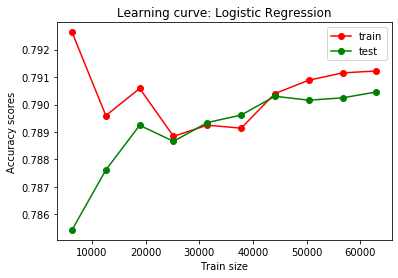

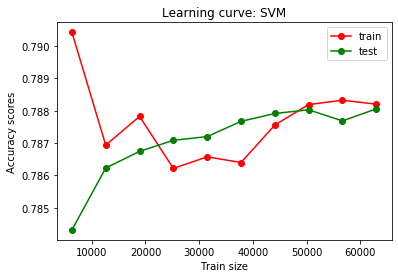

In [78]:
def plot_learning_curve(model_name):
  model = models_tuned[model_name]
  train_sizes, train_scores, test_scores = learning_curve(model, x_train, y_train, train_sizes = np.linspace(0.1,1,10), cv=10)
  plt.figure()
  plt.plot(train_sizes, np.mean(train_scores,axis=1), 'o-', color="r", label="train")
  plt.plot(train_sizes, np.mean(test_scores,axis=1), 'o-', color="g",label="test")
  plt.xlabel("Train size")
  plt.ylabel("Accuracy scores")
  plt.title('Learning curve: {}'.format(model_name))
  plt.legend(loc="best")

  plt.show()

for model_name in ['Logistic Regression','SVM']:
  plot_learning_curve(model_name)

It can be seen from the plots that the models do not overfit since the validation test accuracy steadily goes up and holds at an approximately constant level as the model takes in more data. So let's use the tuned hyper-parameter for evaluation.

### 1.1.3 Test metrics

In [0]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc

In [0]:
def Plot_Metrics(y_test, y_pred, model_name, num_classes):
  cnf_matrix = confusion_matrix(y_test, y_pred)  
  
  fig, ax = plt.subplots()
  sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu" ,fmt='d', linewidths=0.25, xticklabels=list(range(1,num_classes+1)), yticklabels=list(range(1,num_classes+1)))
  plt.title('Confusion matrix: {}'.format(model_name))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


In [0]:
def plot_roc(y_test, y_pred, model_name, num_classes):
  fpr, tpr, threshold = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic: {}'.format(model_name))
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'best')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

score: 0.7890333333333334


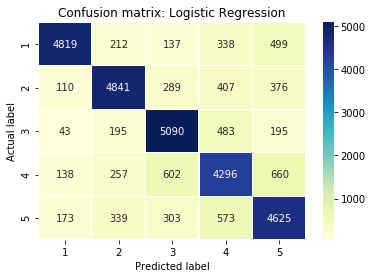

In [40]:
lr_tuned.fit(x_train, y_train)
y_pred = lr_tuned.predict(x_test)
print("score: {}".format(lr_tuned.score(x_test,y_test)))
Plot_Metrics(y_test, y_pred, 'Logistic Regression',5)


score: 0.7866333333333333


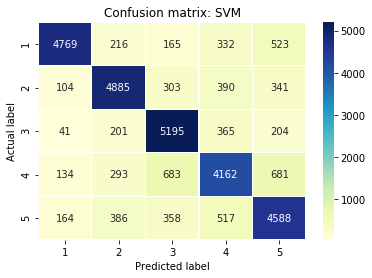

In [51]:
svm_tuned.fit(x_train, y_train)
y_pred = svm_tuned.predict(x_test)
Plot_Metrics(y_test, y_pred, 'SVM', 5)
print("score: {}".format(svm_tuned.score(x_test,y_test)))
# plot_roc(y_test, y_pred, 'SVM')

The reuslts from logistic regression and svm are close (but not good enough) to the baseline accuracy. Let's try some other methods.

### 1.2 Neural Network

### 1.2.1 A single-layer nneural net (logistic regression)

In [26]:
import tensorflow as tf
import keras
#cpu - gpu configuration
config = tf.ConfigProto(device_count = {'GPU': 1 , 'CPU': 1} ) #max: 1 gpu, 56 cpu
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

Using TensorFlow backend.


In [0]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_one_hot = lb.fit_transform(y_train)
y_test_one_hot = lb.transform(y_test)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation

In [57]:

lr_model = Sequential()
lr_model.add(Dense(5, activation = 'sigmoid', input_dim = np.size(x_train[0])))
lr_model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
lr_model.fit(x_train, y_train_one_hot, epochs=20)

lr_test_accuracy = lr_model.evaluate(x_test,y_test_one_hot)[1]
print(lr_test_accuracy)

Epoch 1/20
70000/70000 [==============================] - 8s 117us/step - loss: 1.6024 - acc: 0.2742
Epoch 2/20
70000/70000 [==============================] - 8s 114us/step - loss: 1.5952 - acc: 0.3717
Epoch 3/20
70000/70000 [==============================] - 8s 116us/step - loss: 1.5879 - acc: 0.4906
Epoch 4/20
70000/70000 [==============================] - 8s 114us/step - loss: 1.5801 - acc: 0.5606
Epoch 5/20
70000/70000 [==============================] - 8s 118us/step - loss: 1.5716 - acc: 0.6219
Epoch 6/20
70000/70000 [==============================] - 9s 122us/step - loss: 1.5623 - acc: 0.6505
Epoch 7/20
70000/70000 [==============================] - 11s 151us/step - loss: 1.5519 - acc: 0.6717
Epoch 8/20
70000/70000 [==============================] - 11s 154us/step - loss: 1.5403 - acc: 0.6886
Epoch 9/20
70000/70000 [==============================] - 9s 133us/step - loss: 1.5275 - acc: 0.7012
Epoch 10/20
70000/70000 [==============================] - 8s 119us/step - loss: 1.5134 -

It can be concluded that the algorithm has converged, yielding an accuracy score of 0.746, which I notice is different from the result from that implemented with sklearn. The reasons could be the following:

1. Optimizer - I set the optimizing method of keras Neural Net to be stochastic gradient descent, while sklearn logistic regression uses a different one, lbfgs
2. Regularization - sklearn logistic regression's regularization parameter C is set to 10, while there is no regularizatoin involved in keras Neural Net
3. Random intialization - the weights in Neural Net are randomly initialized

### 1.2.2 multi-layer neural network
Since the result from the single-layer neural network is not satisfying, let's implement a neural network with 3 hidden layers and observe the outcome.

In [0]:
num_classes = 5
nn_model = Sequential()
nn_model.add(Dense(100, input_dim=np.size(x_train[0]), activation='relu'))
nn_model.add(Dense(150, activation='relu'))
nn_model.add(Dense(40, activation='relu'))
nn_model.add(Dense(num_classes, activation='sigmoid'))

In [51]:
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.fit(x_train, y_train_one_hot, epochs=20, batch_size=5000)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20




70000/70000 [==============================] - 3s 48us/step - loss: 0.6733 - acc: 0.7559
Epoch 2/20
70000/70000 [==============================] - 0s 1us/step - loss: 0.6059 - acc: 0.8015
Epoch 3/20
70000/70000 [==============================] - 0s 1us/step - loss: 0.5198 - acc: 0.8000
Epoch 4/20
70000/70000 [==============================] - 0s 2us/step - loss: 0.4730 - acc: 0.8000
Epoch 5/20
70000/70000 [==============================] - 0s 1us/step - loss: 0.4311 - acc: 0.8012
Epoch 6/20
70000/70000 [==============================] - 0s 1us/step - loss: 0.3737 - acc: 0.8334
Epoch 7/20
70000/70000 [==============================] - 0s 1us/step - loss: 0.3144 - acc: 0.8716
Epoch 8/20
70000/70000 [==============================] - 0s 1us/step - loss: 0.2711 - acc: 0.8930
Epoch 9/20
70000/70000 [==============================] - 0s 1us/step - loss: 0.2444 - acc: 0.9054
Epoch 

In [53]:
test_accuracy = nn_model.evaluate(x_test,y_test_one_hot)[1]
print(test_accuracy)

30000/30000 [==============================] - 1s 39us/step
0.9215999935785929


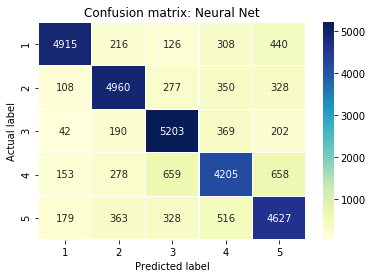

In [79]:
preds = model.predict(x_test)
y_pred = np.argmax(preds, axis=1) + 1
Plot_Metrics(y_test, y_pred, 'Neural Net')

The best performing model for now is undoubtedly the Neural Network with 3 hidden layers, but I noticed in the confusion matrices of the above models, the two classes of 4 and 5 stars have the lowest precision, i.e. the models are biased towards the classes 4 and 5 (or are more likely to wrongly classify other labels as 4 and 5). Let's explore more about it. 

## 2. Further Exploration


 Let's plot the linear correlation matrix between each feature and the label, the bottom line of squares indicates how each feature is correlated with the label.

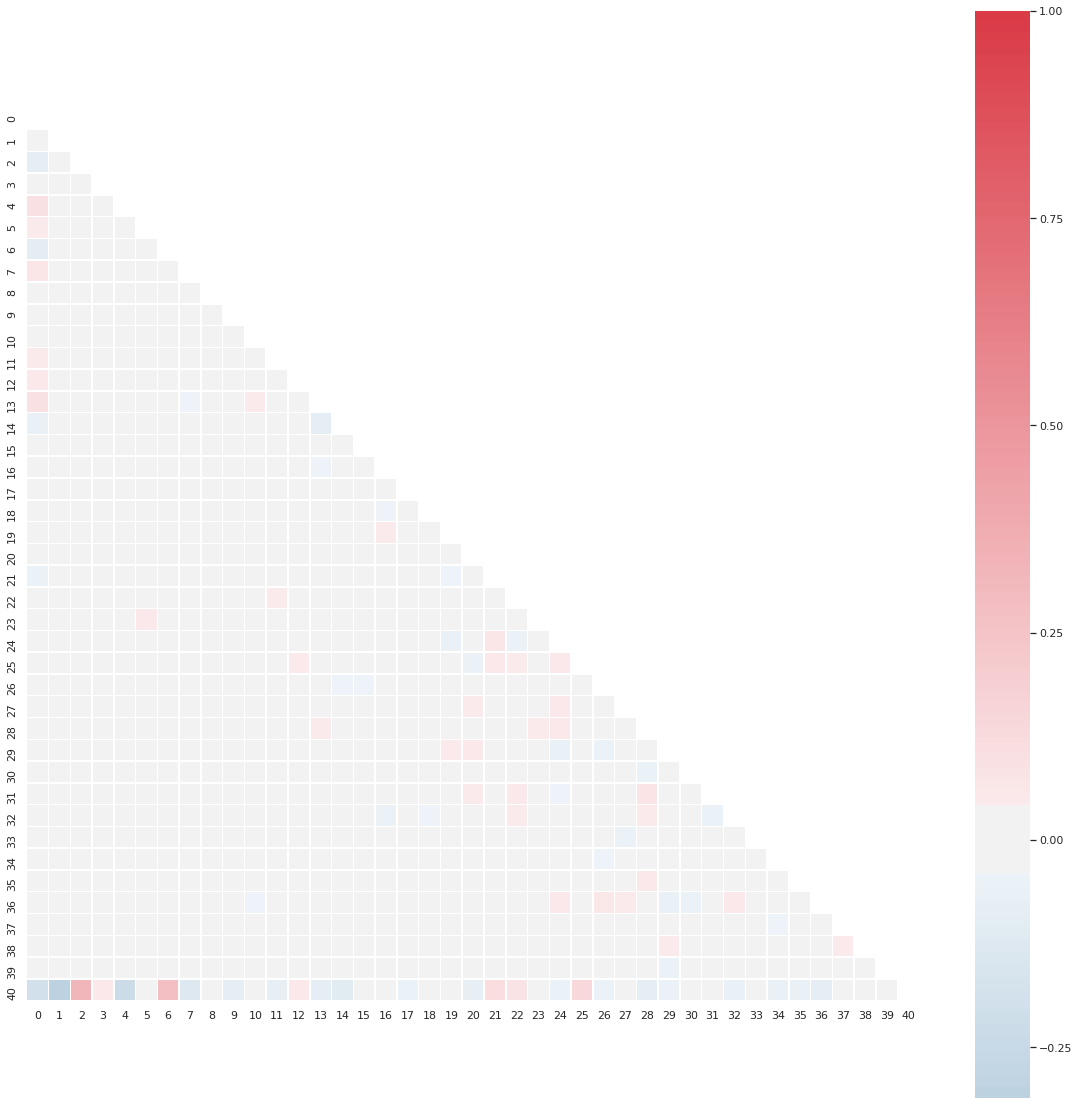

In [27]:
import seaborn as sns 

# The original dataset is so large that the kernel died when computing the correlation matrix
# So I only take a sample of 10000 instances with 2000 in each class
for i in range(1,6):
  index = np.random.choice(np.where(y==i)[0], 2000, replace=False)
  one_class = data[index] 
  one_class = np.hstack((one_class, np.repeat(i,2000).reshape(-1,1)))
  if i == 1:
    subset = one_class
  else:
    subset = np.vstack((subset, one_class))

sns.set(style="white")

corr = np.corrcoef(subset, rowvar=False)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, center=0, square=True, linewidths=.5)
plt.show()
          

As can be seen from the heatmap above, out of the first 8 most significant features, 4 of them are negatively correlated with the label and 3 of them positively. Although the positively correlated features have stronger correlation. Also note most of the squares (correlation coefficients) in the heatmap are grey (no linear correlation), which corresponds to the fact that the data was PCA-processed and the features should be perpendicular to each other. 

### 2.1 Aggregate the labels

 It's likely that only the sentiment of the reviews matter so now let's repartition the star ratings into bad(1,2 stars), neutral(3), and good(4,5). Let's try to classify based on the new classes.

In [34]:
new_class = dict({1:1,2:1,3:2,4:3,5:3})
new_y = np.array(list(map(lambda x: new_class[x], y)))
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(data, new_y, test_size=0.3)
print(Counter(y_train_new))

Counter({1: 28050, 3: 27931, 2: 14019})


Not excatly balanced but it is acceptable. We can always resample or oversample if the result is not satisfactory

0.8488


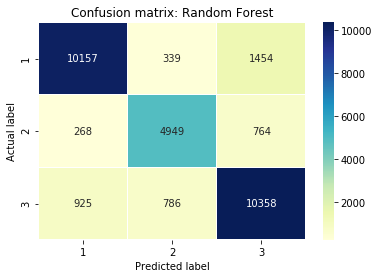

In [41]:
rf = RandomForestClassifier(n_estimators=70).fit(x_train_new, y_train_new)
print(rf.score(x_test_new, y_test_new))
Plot_Metrics(y_test_new, rf.predict(x_test_new), 'Random Forest', 3)

0.8319


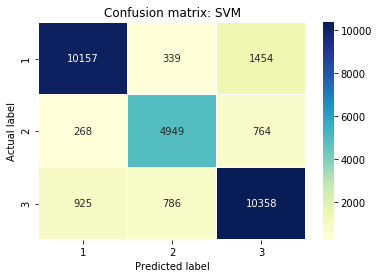

In [43]:
svm_tuned.fit(x_train_new, y_train_new)
print(svm_tuned.score(x_test_new, y_test_new))
Plot_Metrics(y_test_new, rf.predict(x_test_new), 'SVM', 3)

0.8352333333333334


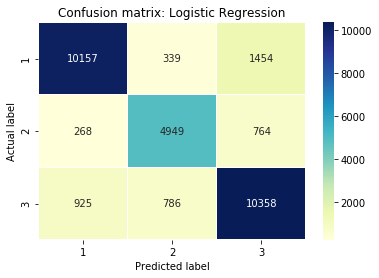

In [44]:
lr_tuned.fit(x_train_new, y_train_new)
print(lr_tuned.score(x_test_new, y_test_new))
Plot_Metrics(y_test_new, rf.predict(x_test_new), 'Logistic Regression', 3)

In [0]:
lb = LabelBinarizer()
y_train_new_one_hot = lb.fit_transform(y_train_new)
y_test_new_one_hot = lb.transform(y_test_new)

In [73]:
num_classes = 3
nn_model = Sequential()
nn_model.add(Dense(80, input_dim=np.size(x_train[0]), activation='relu'))
nn_model.add(Dense(160, activation='relu'))
nn_model.add(Dense(40, activation='relu'))
nn_model.add(Dense(num_classes, activation='sigmoid'))
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.fit(x_train_new, y_train_new_one_hot, epochs=30, batch_size=5000)

Epoch 1/30
70000/70000 [==============================] - 1s 12us/step - loss: 0.6726 - acc: 0.6547
Epoch 2/30
70000/70000 [==============================] - 0s 1us/step - loss: 0.6134 - acc: 0.7082
Epoch 3/30
70000/70000 [==============================] - 0s 1us/step - loss: 0.5462 - acc: 0.6902
Epoch 4/30
70000/70000 [==============================] - 0s 1us/step - loss: 0.4549 - acc: 0.8115
Epoch 5/30
70000/70000 [==============================] - 0s 1us/step - loss: 0.3544 - acc: 0.8633
Epoch 6/30
70000/70000 [==============================] - 0s 1us/step - loss: 0.2894 - acc: 0.8815
Epoch 7/30
70000/70000 [==============================] - 0s 1us/step - loss: 0.2671 - acc: 0.8875
Epoch 8/30
70000/70000 [==============================] - 0s 1us/step - loss: 0.2604 - acc: 0.8900
Epoch 9/30
70000/70000 [==============================] - 0s 1us/step - loss: 0.2565 - acc: 0.8919
Epoch 10/30
70000/70000 [==============================] - 0s 1us/step - loss: 0.2536 - acc: 0.8934
Epoch 11

30000/30000 [==============================] - 2s 54us/step
0.9043889081637064


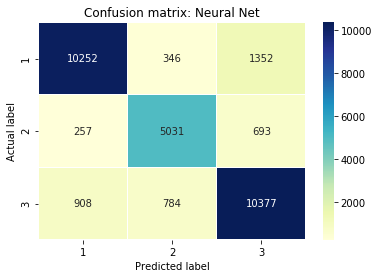

In [74]:
acc = nn_model.evaluate(x_test_new,y_test_new_one_hot)[1]
print(acc)
preds = nn_model.predict(x_test_new)
y_pred = np.argmax(preds, axis=1) + 1
Plot_Metrics(y_test_new, y_pred, 'Neural Net',3)

It can be concluded from above that using 3 classes increased the accuracy of both logistic regression and svm, but not Neural Network, altough the accuracy is still pretty good at 90%.

### 2.2 Linear Regression


After exploring the ratings as categorical values, let's take a look from another perspective: treat the ratings as a continuous variable. The number fo stars can be interpreted as the degree of satisfaction which is not absolute. Intuitively it also makes sense in terms of that it allows wiggle space between ratings.  

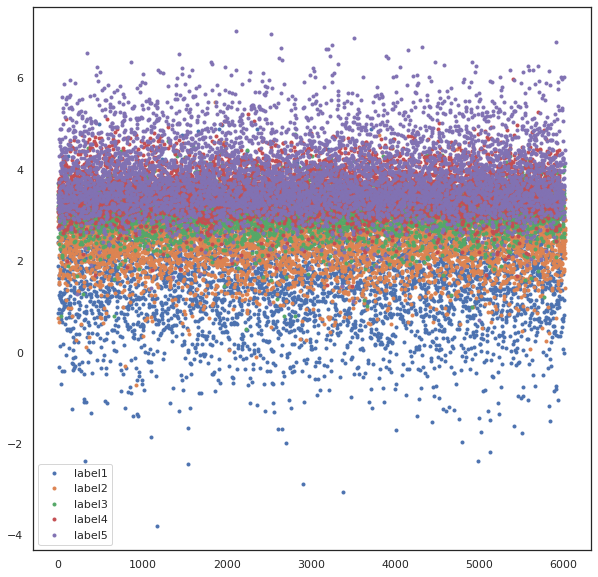

In [28]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression().fit(x_train, y_train)

y_pred = linr.predict(x_test)
plt.figure(figsize=(10,10))
for i in range(1,6):
  plt.plot(y_pred[np.where(y_test == i)[0]],'o', markersize=3, label='label'+str(i))
plt.legend(loc='best')
plt.show()

That doesn't even need a score to tell that linear regression fails to distinguish different labels, 3,4 and 5 in particular, whose straps are almost overlapping. 

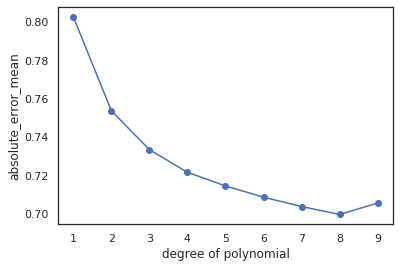

In [38]:
absolute_error_mean = []
for i in range(1,10):
  if i == 1:
    x_train_poly = x_train
    x_test_poly = x_test
  else:
    x_train_poly = np.hstack((x_train_poly, x_train**i))
    x_test_poly = np.hstack((x_test_poly, x_test**i))
  linr = LinearRegression().fit(x_train_poly, y_train)
  y_pred = linr.predict(x_test_poly)
  e = np.sum(np.abs(y_test - y_pred))/len(y_pred)
  absolute_error_mean.append(e)

plt.plot(list(range(1,10)),absolute_error_mean,'-o')
plt.xlabel('degree of polynomial')
plt.ylabel('absolute_error_mean')
plt.show()

The plot suggests that the most optimal mean absolute error can be achived by this linear regression is about 0.7. It is not ideal because the class difference is 1 and 0.7 is too much an error to be predicting accurately.

## 3. Conclusion and Future Work
The best model for the task is the Neural Network with 3 hidden layers done in 1.2.2 with an accuracy score at around 92%. 

Future work includes:
1. try adaboost to solve the problem that the models seems to prefer class with higher ratings
2. Use AUC ROC to evaluate the models
